<a href="https://colab.research.google.com/github/hassiahk/RC2020-Double-Hard-DeBias/blob/main/notebooks/rc2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install wandb -qqq
import wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.init(project="rc2020")

In [ ]:
!gdown --id 1jrbQmpB5ZNH4w54yujeAvNFAfVEG0SuE

Downloading...
From: https://drive.google.com/uc?id=1jrbQmpB5ZNH4w54yujeAvNFAfVEG0SuE
To: /content/GloVe.zip
368MB [00:03, 102MB/s] 


In [ ]:
!cd /content/drive/MyDrive/double-debaising/Double-Hard-Debias/data

In [ ]:
!unzip GloVe.zip

Archive:  GloVe.zip
  inflating: vectors.txt             


In [ ]:
!cp /content/vectors.txt "/content/drive/My Drive/PaperReproducibility/vectors.txt"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/double-debaising/Double-Hard-Debias')

In [3]:
import codecs, os, json, operator, pickle
from random import shuffle
import numpy as np
from numpy import linalg as LA
import scipy

%load_ext autoreload
%autoreload 2

In [4]:
def load_glove(path):
    with open(path) as f:
        lines = f.readlines()
    
    word_vec = []
    vocab = []
    for line in lines:
        tokens = line.strip().split(" ")
        assert len(tokens) == 301
        vocab.append(tokens[0])
        word_vec.append([float(elem) for elem in tokens[1:]])
    w2i = {w: i for i, w in enumerate(vocab)}
    word_vec = np.array(word_vec).astype(float)
    print(len(vocab), word_vec.shape, len(w2i))
    
    return word_vec, w2i, vocab

word_vec, w2i, vocab = load_glove('/content/drive/MyDrive/double-debaising/Double-Hard-Debias/data/vectors.txt')

322636 (322636, 300) 322636


In [5]:
# word_vec = wv
word2idx = w2i # mapping each word with indices 

In [ ]:
# vocab
word_vec[word2idx["personal"]].shape

(300,)

In [6]:
# del(wv)
del(w2i)

In [7]:
def getWordVector (word) : 
  return word_vec[word2idx[word]]

In [9]:
import json
from tqdm import tqdm
from utils import limit_vocab


gender_specific = []
with open('/content/drive/MyDrive/double-debaising/Double-Hard-Debias/data/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('/content/drive/MyDrive/double-debaising/Double-Hard-Debias/data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('/content/drive/MyDrive/double-debaising/Double-Hard-Debias/data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

definitional_pairs = [['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], 
                      ['girl', 'boy'], ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], 
                      ['gal', 'guy'], ['female', 'male']]
definitional_words = [word for pair in definitional_pairs for word in pair]

assert (len(definitional_pairs) == len(definitional_words)/2)
assert (definitional_pairs[0][0] == definitional_words[0])

exclude_words = gender_specific

vocab_limit, word_vec_limit, word2idx_limit = limit_vocab(word_vec, word2idx, vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 412056.24it/s]


size of vocabulary: 47628


In [10]:
he_embed = word_vec[word2idx['he'], :]
she_embed = word_vec[word2idx['she'], :]


# All words in vocab_limit should have zero gender bias. 
# So bias[word] = difference between its similarity to 'he' and 'she' vectors.

# people use the cosine similarity as a similarity metric between vectors. 
# Now, the distance can be defined as 1-cos_similarity. 
# The intuition behind this is that if 2 vectors are perfectly the same 
# then similarity is 1 (angle=0) and thus, distance is 0
def similarity(a, b):
    return 1 - scipy.spatial.distance.cosine(a, b)    #1 - cosine distance = cosine similarity

def compute_bias_by_projection(word_vec, word2idx, vocab):
    d = {}
    for w in vocab:
        w_vec = word_vec[word2idx[w], :]
        # There should not be any difference in 'he' similarity and 'she' similarity for a gender neutral word
        # Calculating difference between similarities of "he" and "she" similarity
        d[w] = similarity(w_vec, he_embed) - similarity(w_vec, she_embed)
    return d
    
# If differences is > 0 then word is male baised and if < 0 then word is female biased.
gender_bias_bef = compute_bias_by_projection(word_vec_limit, word2idx_limit, vocab_limit)

In [11]:
len(gender_bias_bef)

47628

In [12]:
differences = gender_bias_bef['teacher']
if differences > 0:
  print("Given word is Male biased")
elif differences < 0:
  print("Given word is Female biased")
else:
  print("Given word is unbiased")


Given word is Female biased


In [13]:
from sklearn.decomposition import PCA

# get main PCA components for removing frequency bias
def my_pca(wv):
    wv_mean = np.mean(np.array(wv), axis=0)
    wv_hat = np.zeros(wv.shape).astype(float)

    #can we do this with broadcasting?? Yes we can

    wv_hat = wv - wv_mean 
    #for i in range(len(wv)):
        #wv_hat[i, :] = wv[i, :] - wv_mean

    #print(wv_hat.shape)
    #print(np.mean(wv_hat, axis = 0))
    #print(np.mean(np.array(wv_hat), axis=0))
    main_pca = PCA()
    main_pca.fit(wv_hat)
    
    return main_pca

main_pca = my_pca(word_vec)
wv_mean = np.mean(np.array(word_vec), axis=0)

In [ ]:
word_vec.shape

(322636, 300)

In [ ]:
main_pca.components_.shape

(300, 300)

In [ ]:
main_pca.components_[0].shape

(300,)

In [ ]:
np.linalg.norm(main_pca.components_[0])

1.0

In [14]:
def hard_debias(wv, w2i, w2i_partial, vocab_partial, component_id):
    
    # D = []
    d = main_pca.components_[component_id]
    # for i in component_ids:
        #D.append(main_pca.components_[i])
    # Length of D is always 1, it captures the ith component of main_pca.components_

    # get rid of frequency features
    wv_f = np.zeros((len(vocab_partial), wv.shape[1])).astype(float)
    print(wv_f.shape)

    #Debiasing frequency from word vectors
    for voc_idx, word in enumerate(vocab_partial):

        u = wv[w2i[word], :]    # Get vector for word in vocab_partial-> len(vocab_partial) = 2019
        # wv_mean = np.mean(u,axis=0)
        
        sub = np.zeros(u.shape).astype(float)
        #for d in D:      # Eigen Vector of word vectors
            #sub += np.dot(np.dot(np.transpose(d), u), d)   #Understand this for PCA implementation!!
        sub += np.dot(np.dot(np.transpose(d), u), d)     # d is unit vector
        wv_f[w2i_partial[word], :] = u - sub - wv_mean    # removing component of 'u' in direction of 'd' (u - (u.v^)v^)
                                                          # consider v^ to be unit vector.
        #Why would we subtract mean here, clearly the sub would change the mean of the data
    
    mean_wv_f = np.mean(np.array(wv_f), axis=0)
    # print(mean_wv_f)
    #wv_f is not origin centred! 

    #Debias Gender Direction
    gender_directions = list()
    #for gender_word_list in [definitional_pairs]:
        #gender_directions.append(doPCA(gender_word_list, wv_f, w2i_partial).components_[0])

    # Bolukbasi gender debias : Take 10 gender pairs (he : she), calculate gender direction, apply PCA and take first eigen vector of it
    gender_directions.append(doPCA(definitional_pairs, wv_f, w2i_partial).components_[0])

    wv_debiased = np.zeros((len(vocab_partial), len(wv_f[0, :]))).astype(float)
    for i, w in enumerate(vocab_partial):
        u = wv_f[w2i_partial[w], :]
        for gender_direction in gender_directions:
            u = drop(u, gender_direction)
            wv_debiased[w2i_partial[w], :] = u
    
    return wv_debiased

In [ ]:
word_vec[0].shape

(300,)

In [15]:
from sklearn.cluster import KMeans
def cluster_and_visualize(words, X, random_state, y_true, num=2):
    
    kmeans = KMeans(n_clusters=num, random_state=random_state).fit(X)
    y_pred = kmeans.predict(X)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred) ]     #If male denotes '1' in y_true, how can we be sure y_pred will denote male with '1'
                                                                                         #lucky guess since seed is fixed
    preci = max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct)))
    print('precision', preci)
    
    return kmeans, y_pred, X, preci

In [19]:
sorted(gender_bias_bef.items(), key=operator.itemgetter(1))

[('eniwetok', -0.2271241787858822),
 ('ulithi', -0.22552919159831608),
 ('majuro', -0.22226947987976708),
 ('laura', -0.2214269365803906),
 ('transited', -0.21847881712986927),
 ('homeport', -0.21403074129714517),
 ('alumna', -0.21371639275002563),
 ('replenishment', -0.2136236512464309),
 ('kwajalein', -0.21304014867528076),
 ('steamed', -0.2123797047080589),
 ('refit', -0.20710440844373956),
 ('gabriela', -0.20673095949636966),
 ('katie', -0.20626780720313354),
 ('steaming', -0.20370022294508783),
 ('rachel', -0.19986917762299683),
 ('saipan', -0.19926636010793952),
 ('tomboy', -0.19734658861977217),
 ('natalie', -0.19668425470901973),
 ('subic', -0.1963042100839969),
 ('louise', -0.19513024507993437),
 ('moored', -0.19476420730317068),
 ('amanda', -0.19457054381743066),
 ('tatiana', -0.1940152567320138),
 ('nina', -0.19301860004039462),
 ('scuttled', -0.19142955766574032),
 ('susan', -0.19075214106161464),
 ('emily', -0.19074752653651306),
 ('handbag', -0.1906184287661743),
 ('laure

In [16]:
from utils import extract_vectors
from utils import train_and_predict
from utils import doPCA, drop

size=1000    #why this size??
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1)) # default order is ascending
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
#getting top thousand male and female biased terms
y_true = [1]*size + [0]*size

c_vocab = list(set(male + female + [word for word in definitional_words if word in word2idx]))
#c_vocab (vocab_partial) contains set of biased words 
c_w2i = dict()
for idx, w in enumerate(c_vocab):
    c_w2i[w] = idx
    
precisions = []
    
#what is component_id ?
#Set of eigen vectors, why range is 20??
for component_id in range(20):
    
    print('component id: ', component_id)
    
    wv_debiased = hard_debias(word_vec, word2idx, w2i_partial = c_w2i, vocab_partial = c_vocab, component_id = component_id)
    kmeans, y_pred, _, preci = cluster_and_visualize(male + female, 
                                           extract_vectors(male + female, wv_debiased, c_w2i), 1, y_true)
    precisions.append(preci)

component id:  0
(2019, 300)
pairs used in PCA:  10
precision 0.817
component id:  1
(2019, 300)
pairs used in PCA:  10
precision 0.704
component id:  2
(2019, 300)
pairs used in PCA:  10
precision 0.8145
component id:  3
(2019, 300)
pairs used in PCA:  10
precision 0.816
component id:  4
(2019, 300)
pairs used in PCA:  10
precision 0.802
component id:  5
(2019, 300)
pairs used in PCA:  10
precision 0.775
component id:  6
(2019, 300)
pairs used in PCA:  10
precision 0.785
component id:  7
(2019, 300)
pairs used in PCA:  10
precision 0.8025
component id:  8
(2019, 300)
pairs used in PCA:  10
precision 0.807
component id:  9
(2019, 300)
pairs used in PCA:  10
precision 0.815
component id:  10
(2019, 300)
pairs used in PCA:  10
precision 0.812
component id:  11
(2019, 300)
pairs used in PCA:  10
precision 0.818
component id:  12
(2019, 300)
pairs used in PCA:  10
precision 0.8180000000000001
component id:  13
(2019, 300)
pairs used in PCA:  10
precision 0.8045
component id:  14
(2019, 300

In [ ]:
ls

drive/  GloVe.zip  sample_data/  voc.txt


In [ ]:
with open('./voc.txt', 'w') as outFile : 
  for word in c_vocab : 
    outFile.write(word + "\n")

In [ ]:
kmeans.predict(word_vec[word2idx['he']].reshape(1, -1))

array([1], dtype=int32)

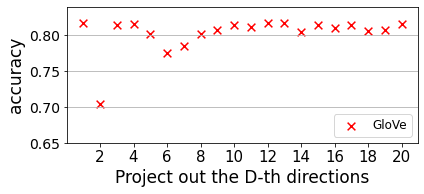

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(1, 21)
data1 = precisions

fig, ax1 = plt.subplots(figsize=(6,2.8))

color = 'red'
ax1.set_xlabel('Project out the D-th directions', fontsize=17)
ax1.set_ylabel('accuracy', fontsize=17)
ax1.scatter(t, data1, color=color, label='GloVe', marker = 'x', s=60)
plt.xticks([2,4,6,8,10, 12, 14, 16 ,18, 20], fontsize=15)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylim(0.65, 0.84)
ax1.legend(loc='lower right', frameon=True, fontsize='large')
ax1.grid(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# wandb.log({"Accuracy": wandb.Image(fig)}, commit=True)
plt.show()

# Glove_eval.py from here.

In [ ]:
cd '/content/drive/MyDrive/double-debaising/Double-Hard-Debias'

/content/drive/MyDrive/double-debaising/Double-Hard-Debias


In [ ]:
import codecs, os, json, operator, pickle
from random import shuffle
import numpy as np
from numpy import linalg as LA
import scipy

%load_ext autoreload
%autoreload 2

In [ ]:
def load_glove(path):
    with open(path) as f:
        lines = f.readlines()
    
    word_vec = []
    vocab = []
    for line in lines:
        tokens = line.strip().split(" ")
        try:
            assert len(tokens) == 301
            vocab.append(tokens[0])
            word_vec.append([float(elem) for elem in tokens[1:]])
        except:
            print(line)
        
    word2index = {w: i for i, w in enumerate(vocab)}
    word_vec = np.array(word_vec).astype(float)
    print(len(vocab), word_vec.shape, len(word2index))
    
    return word_vec, word2index, vocab

def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

# this function mainly checks length of word_vec and reverses word_vec 
def debias_gn(wv):
    for v in wv:
        assert(len(v) == 300)
    
    wv = wv[:,:-1]

    for v in wv:
        assert(len(v) == 299)
    return wv

In [ ]:
glove, glove_w2i, vocab = load_glove("./data/vectors.txt")
gn_glove, gn_glove_w2i, gn_vocab = load_glove("./data/vectors300.txt")
gn_glove_a = debias_gn(gn_glove)

322636 (322636, 300) 322636
322636 (322636, 300) 322636


In [ ]:
# len(gn_glove)
# len(gn_glove)
gn_glove.shape
gn_glove_a.shape

(322636, 299)

In [ ]:
def load_glove_p(path):
    
    debiased_embeds = pickle.load(open(path, 'rb'))
    wv = []
    vocab = []
    for w in debiased_embeds:
        wv.append(np.array(debiased_embeds[w]))
        vocab.append(str(w))
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.array(wv).astype(float)
    print(len(vocab), wv.shape, len(w2i))
        
    return wv, w2i, vocab

#dhd --> double hard debias   
dhd_glove, dhd_glove_w2i, dhd_vocab = load_glove_p("./data/glove_dhd.p")

322636 (322636, 300) 322636


In [ ]:
# hd -> hard debias
hd_glove, hd_glove_w2i, hd_vocab = load_glove(
    "./data/vectors_hd.txt")

# why we have not removed last column here?
# basically what is _a represnets
hd_glove_a, hd_glove_a_w2i, hd_vocab_a = load_glove(
    "./data/vectors_hd_a.txt")

322636 (322636, 300) 322636
322636 (322636, 300) 322636


In [ ]:
gp_glove, gp_glove_w2i, gp_vocab = load_glove(
    "./data/gp_glove.txt")
gp_gn_glove, gp_gn_glove_w2i, gp_gn_vocab = load_glove(
    "./data/gp_gn_glove.txt")

322636 300

322636 (322636, 300) 322636
322636 300

322636 (322636, 300) 322636


In [ ]:
def similarity(a, b):
    return 1-scipy.spatial.distance.cosine(a, b)

In [ ]:
cd /content/drive/MyDrive/double-debaising/Double-Hard-Debias

/content/drive/MyDrive/double-debaising/Double-Hard-Debias


# Setting up word-embeddings benchmark

In [ ]:
!git clone https://github.com/kudkudak/word-embeddings-benchmarks.git

Cloning into 'word-embeddings-benchmarks'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 730 (delta 0), reused 3 (delta 0), pack-reused 726
Receiving objects: 100% (730/730), 183.33 KiB | 2.55 MiB/s, done.
Resolving deltas: 100% (483/483), done.


In [ ]:
cd word-embeddings-benchmarks

/content/drive/My Drive/double-debaising/Double-Hard-Debias/word-embeddings-benchmarks


In [ ]:
!python setup.py install

In [ ]:
pip install -r requirements.txt

In [ ]:
cd /content/drive/MyDrive/double-debaising/Double-Hard-Debias

/content/drive/MyDrive/double-debaising/Double-Hard-Debias


# Now continuing with code

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/double-debaising/Double-Hard-Debias/word-embeddings-benchmarks')

In [ ]:
from eval import evaluate_cate, evaluate_ana, evaluate_analogy_google, evaluate_analogy_msr

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
evaluate_cate(glove, glove_w2i, vocab)

Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is assigned class edible_fruit
exist 401 in 402
Cluster purity on AP 0.5635910224438903
Sample data from ESSLI_2c, num of samples: 45 : "['kill']" is assigned class changeState-changeState
exist 45 in 45
Cluster purity on ESSLI_2c 0.5777777777777778
Sample data from ESSLI_2b, num of samples: 40 : "['jealousy']" is assigned class LO
exist 40 in 40
Cluster purity on ESSLI_2b 0.775
Sample data from ESSLI_1a, num of samples: 44 : "['bottle']" is assigned class tool-artifact
exist 44 in 44
Cluster purity on ESSLI_1a 0.7272727272727273
Sample data from Battig, num of samples: 5231 : "robin" is assigned class bird
exist 4125 in 5231
Cluster purity on Battig 0.509090909090909
Sample data from BLESS, num of samples: 200 : "['bag']" is assigned class container
exist 200 in 200
Cluster purity on BLESS 0.81


In [ ]:
evaluate_cate(hd_glove, hd_glove_w2i, hd_vocab)
evaluate_cate(hd_glove_a, hd_glove_a_w2i, hd_vocab_a)

Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is assigned class edible_fruit
exist 401 in 402
Cluster purity on AP 0.6059850374064838
Sample data from ESSLI_2c, num of samples: 45 : "['kill']" is assigned class changeState-changeState
exist 45 in 45
Cluster purity on ESSLI_2c 0.6444444444444445
Sample data from ESSLI_2b, num of samples: 40 : "['jealousy']" is assigned class LO
exist 40 in 40
Cluster purity on ESSLI_2b 0.8
Sample data from ESSLI_1a, num of samples: 44 : "['bottle']" is assigned class tool-artifact
exist 44 in 44
Cluster purity on ESSLI_1a 0.7954545454545455
Sample data from Battig, num of samples: 5231 : "robin" is assigned class bird
exist 4125 in 5231
Cluster purity on Battig 0.5081212121212121
Sample data from BLESS, num of samples: 200 : "['bag']" is assigned class container
exist 200 in 200
Cluster purity on BLESS 0.845
Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is assi

In [ ]:
evaluate_cate(gn_glove, gn_glove_w2i, gn_vocab)
evaluate_cate(gn_glove_a, gn_glove_w2i, gn_vocab)

Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is assigned class edible_fruit
exist 401 in 402
Cluster purity on AP 0.5685785536159601
Sample data from ESSLI_2c, num of samples: 45 : "['kill']" is assigned class changeState-changeState
exist 45 in 45
Cluster purity on ESSLI_2c 0.6222222222222222
Sample data from ESSLI_2b, num of samples: 40 : "['jealousy']" is assigned class LO
exist 40 in 40
Cluster purity on ESSLI_2b 0.75
Sample data from ESSLI_1a, num of samples: 44 : "['bottle']" is assigned class tool-artifact
exist 44 in 44
Cluster purity on ESSLI_1a 0.7045454545454546
Sample data from Battig, num of samples: 5231 : "robin" is assigned class bird
exist 4125 in 5231
Cluster purity on Battig 0.5044848484848484
Sample data from BLESS, num of samples: 200 : "['bag']" is assigned class container
exist 200 in 200
Cluster purity on BLESS 0.85
Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is assi

In [ ]:
evaluate_cate(gp_glove, gp_glove_w2i, gp_vocab)
evaluate_cate(gp_gn_glove, gp_gn_glove_w2i, gp_gn_vocab)
evaluate_cate(dhd_glove, dhd_glove_w2i, dhd_vocab)

Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is assigned class edible_fruit
exist 401 in 402
Cluster purity on AP 0.5610972568578554
Sample data from ESSLI_2c, num of samples: 45 : "['kill']" is assigned class changeState-changeState
exist 45 in 45
Cluster purity on ESSLI_2c 0.5777777777777778
Sample data from ESSLI_2b, num of samples: 40 : "['jealousy']" is assigned class LO
exist 40 in 40
Cluster purity on ESSLI_2b 0.775
Sample data from ESSLI_1a, num of samples: 44 : "['bottle']" is assigned class tool-artifact
exist 44 in 44
Cluster purity on ESSLI_1a 0.7272727272727273
Sample data from Battig, num of samples: 5231 : "robin" is assigned class bird
exist 4125 in 5231
Cluster purity on Battig 0.4896969696969697
Sample data from BLESS, num of samples: 200 : "['bag']" is assigned class container
exist 200 in 200
Cluster purity on BLESS 0.785
Calculating categorization benchmarks
Sample data from AP, num of samples: 402 : "['apple']" is as

In [ ]:
# check line no. 343 in eval file for the path
# look for that path, need to find it
# https://github.com/stanfordnlp/GloVe/tree/master/eval/question-data
# found this path but it doesn't contain file which is mentioned in code.
evaluate_ana(hd_glove_a, hd_glove_a_w2i, hd_vocab_a)
evaluate_ana(gn_glove_a, gn_glove_w2i, gn_vocab)
evaluate_ana(gp_glove, gp_glove_w2i, gp_vocab)
evaluate_ana(gp_gn_glove, gp_gn_glove_w2i, gp_gn_vocab)

FileNotFoundError: ignored

In [ ]:
evaluate_ana(dhd_glove, dhd_glove_w2i, dhd_vocab)

FileNotFoundError: ignored

In [ ]:
from tqdm import tqdm
from utils import limit_vocab

gender_specific = []

with open('./data/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
print(len(gender_specific))

with codecs.open('./data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))


exclude_words = gender_specific
print(len(exclude_words))

glove_vocab_limit, glove_limit, glove_w2i_limit = limit_vocab(glove, glove_w2i, vocab, exclude = exclude_words)

442


100%|██████████| 50000/50000 [00:00<00:00, 383147.13it/s]

1883
size of vocabulary: 47628


In [ ]:
gn_vocab_limit, gn_limit, gn_w2i_limit = limit_vocab(gn_glove, gn_glove_w2i, gn_vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 385930.12it/s]


size of vocabulary: 47628


In [ ]:
gn_a_vocab_limit, gn_a_limit, gn_a_w2i_limit = limit_vocab(
    gn_glove_a, gn_glove_w2i, gn_vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 397978.56it/s]


size of vocabulary: 47628


In [ ]:
gp_vocab_limit, gp_limit, gp_w2i_limit = limit_vocab(
    gp_glove, gp_glove_w2i, gp_vocab, exclude = exclude_words)
gp_gn_vocab_limit, gp_gn_limit, gp_gn_w2i_limit = limit_vocab(
    gp_gn_glove, gp_gn_glove_w2i, gp_gn_vocab, exclude = exclude_words)

hd_vocab_limit, hd_limit, hd_w2i_limit = limit_vocab(
    hd_glove, hd_glove_w2i, hd_vocab, exclude = exclude_words)
hd_a_vocab_limit, hd_a_limit, hd_a_w2i_limit = limit_vocab(
    hd_glove_a, hd_glove_a_w2i, hd_vocab_a, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 391600.16it/s]


size of vocabulary: 47628


100%|██████████| 50000/50000 [00:00<00:00, 356186.01it/s]


size of vocabulary: 47628


100%|██████████| 50000/50000 [00:00<00:00, 368374.44it/s]


size of vocabulary: 47628


100%|██████████| 50000/50000 [00:00<00:00, 376910.39it/s]


size of vocabulary: 47628


In [ ]:
dhd_vocab_limit, dhd_limit, dhd_w2i_limit = limit_vocab(
    dhd_glove, dhd_glove_w2i, dhd_vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 372187.85it/s]


size of vocabulary: 47628


In [ ]:
he_embed = glove[glove_w2i['he'], :]
she_embed = glove[glove_w2i['she'], :]

def similarity(a, b):
    return 1-scipy.spatial.distance.cosine(a, b)

def compute_bias_by_projection(wv, w2i, vocab):
    d = {}
    for w in vocab:
        u = wv[w2i[w], :]
        d[w] = similarity(u, he_embed) - similarity(u, she_embed)
    return d

gender_bias_bef = compute_bias_by_projection(glove_limit, glove_w2i_limit, glove_vocab_limit)
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))

In [ ]:
def visualize(vectors, y_true, y_pred, ax, title, random_state):
    
    # perform TSNE
    vectors = normalize(vectors)
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    for x,p,y in zip(X_embedded, y_pred, y_true):
        if y:
            ax.scatter(x[0], x[1], marker = '.', c = 'c')
        else:
            ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    
    return ax

def cluster_and_visualize(words, X1, title, random_state, tsne_random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax1 = visualize(X1, y_true, y_pred_1, axs, title, tsne_random_state)
    
#     fig.savefig("a_{}_{}_{}.pdf".format(title, size, random_state))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from utils import extract_vectors
import operator
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

size=200
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

In [ ]:
# You may change the random states to get more visualization result
random_state = 0
tsne_random_state = 5

precision 1.0


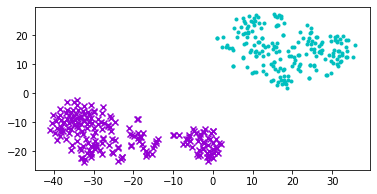

In [ ]:
cluster_and_visualize(male + female, extract_vectors(male + female, glove_limit, glove_w2i_limit), 
                          'GloVe', random_state, tsne_random_state, y_true)

precision 0.7775


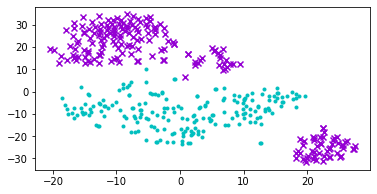

In [ ]:
cluster_and_visualize(male + female, extract_vectors(male + female, hd_limit, hd_w2i_limit), 
                          'Hard-GloVe', random_state, tsne_random_state, y_true)

precision 0.7775


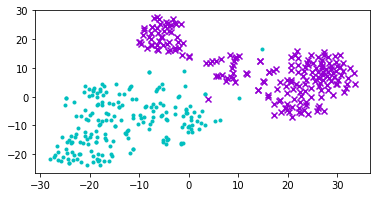

In [ ]:
cluster_and_visualize(male + female, extract_vectors(male + female, hd_a_limit, hd_a_w2i_limit), 
                          ' Strong-Hard-GloVe', random_state, tsne_random_state, y_true)

precision 0.6225


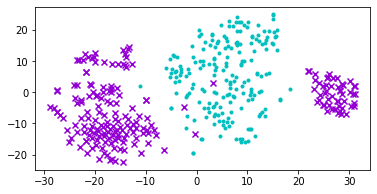

In [ ]:
cluster_and_visualize(male + female, extract_vectors(male + female, dhd_limit, dhd_w2i_limit), 
                          'Double-Hard-GloVe', random_state, tsne_random_state, y_true)

precision 1.0


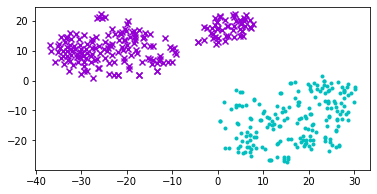

In [ ]:
cluster_and_visualize(male + female, extract_vectors(male + female, gn_limit, gn_w2i_limit), 
                          'GN-GloVe', random_state, tsne_random_state, y_true)

In [ ]:
def cluster(words, X1, random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))

In [ ]:
# Cluster most biased words before and after debiasing

def my_cluster(wv, w2i, start=0, size=500, random_state = 1):
    
    if start == 0:
        female = [item[0] for item in sorted_g[:size]]
        male = [item[0] for item in sorted_g[-size:]]
    else:
        female = [item[0] for item in sorted_g[start:size+start]]
        male = [item[0] for item in sorted_g[-(start+size):-start]]

    y_true = [1]*size + [0]*size
    
    cluster(male + female, extract_vectors(male + female, wv, w2i), random_state, y_true)

In [ ]:
random_state_=0
start=0
end=100
my_cluster(glove_limit, glove_w2i_limit, start, end, random_state=random_state_)
my_cluster(hd_limit, hd_w2i_limit, start, end, random_state=random_state_)
my_cluster(hd_a_limit, hd_a_w2i_limit, start, end, random_state=random_state_)
my_cluster(gn_limit, gn_w2i_limit, start, end, random_state=random_state_)
my_cluster(gn_a_limit, gn_a_w2i_limit, start, end, random_state=random_state_)
my_cluster(gp_limit, gp_w2i_limit, start, end, random_state=random_state_)
my_cluster(gp_gn_limit, gp_gn_w2i_limit, start, end, random_state=random_state_)
my_cluster(dhd_limit, dhd_w2i_limit, start, end, random_state=random_state_)

precision 1.0
precision 0.765
precision 0.765
precision 1.0
precision 1.0
precision 1.0
precision 1.0
precision 0.665
